In [27]:
import torch
from torch.optim import Adam

import numpy as np
from matplotlib import pyplot as plt
import PIL.Image as Image

from pandas import read_fwf, DataFrame
from tqdm   import tqdm_notebook as tqdm

import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.autograd import Variable

from torchvision import transforms
from torchvision import datasets
import time

In [28]:
from radioreader import *
from methods import *
from kittler import kittler_float

In [29]:
directory = 'unlrg'
ext = 'fits'
names = glob.glob('{0}/*.{1}*'.format(directory, ext))
images = []
for n in tqdm(range(len(names))):
    im = readImg(names[n], normalize=True, sz=128)
    k = kittler_float(im, copy=False)
    images.append( np.expand_dims(k, axis=0) )
    del im
    del k
print("Number of images", len(images))


Number of images 1442


In [30]:
class UNLRG(data.Dataset):
    def __init__(self, images, transform=None):
        self.data = images
        self.data_len = len(self.data)
        if(transform == None):
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(180),
#                 transforms.RandomResizedCrop((128,128),(.5,1)),
                transforms.ToTensor()])
        else : self.transform = transform

#     def __load_data
            
    def __getitem__(self, index):
        index = index % self.data_len
        np_arr = self.data[index, :]
        ## reshape np_arr to 28x28
        np_arr = np_arr.reshape(128, 128)

        ## convert to PIL-image
        img = Image.fromarray((np_arr*255).astype('uint8'))

        #apply the transformations and return tensors
        return self.transform(img)
    def __len__(self):
        return self.data_len * 10
    def __repr__(self) -> str:
        return 'unLRG dataset'

In [31]:
images = np.array(images)
dataset = UNLRG(images)

In [32]:
np.max(images)

0.9992211085045712

In [33]:
class VAE(nn.Module):
    def __init__(self, lt_dim=8):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d( 1,  8, 3, 2, 1, 1),
            nn.ReLU(),
            nn.Conv2d( 8,  8, 3, 2, 1, 1),
            nn.ReLU(),
            nn.Conv2d( 8, 16, 3, 2, 1, 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 2, 1, 1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, 3, 2, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, 2, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, 2, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d( 8,  8, 3, 2, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d( 8,  1, 3, 2, 1, 1),
            nn.Sigmoid()
        )
        self.fc_mu = nn.Linear(32*4*4, lt_dim)
        self.fc_ep = nn.Linear(32*4*4, lt_dim)
        
        self.fc_dc = nn.Linear(lt_dim, 32*4*4)
    def encode(self, x):
        encoded = self.encoder(x).view(-1, 32*4*4)
        return self.fc_mu(encoded), self.fc_ep(encoded)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, x):
        x = F.relu(self.fc_dc(x)).view(-1, 32, 4, 4)
        return self.decoder(x)
    
    def forward(self, x):
        mu, var = self.encode(x)
        z = self.reparameterize(mu, var)
        d = self.decode(z)
        return d, mu, var
    
class Discriminator(nn.Module):
    def __init__(self, sz=32*4*4):
        super(Discriminator, self).__init__()
        self.sz = sz
        self.encoder = nn.Sequential(
            nn.Conv2d( 1,  8, 3, 2, 1, 1),
            nn.ReLU(),
            nn.Conv2d( 8,  8, 3, 2, 1, 1),
            nn.ReLU(),
            nn.Conv2d( 8, 16, 3, 2, 1, 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 2, 1, 1),
            nn.ReLU()
        )
        self.main = nn.Sequential(
            nn.Linear(self.sz, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.encoder(x).view(-1, self.sz)
        x = self.main(x)
        return x

In [34]:
data_loader = data.DataLoader(dataset, batch_size=64, shuffle=False)
# sample = iter(data_loader).next()

In [35]:
device = 'cuda'

vae = VAE().to(device)
dis = Discriminator().to(device)

optimizer  = Adam(vae.parameters(), lr=0.001)
optimizerD = Adam(dis.parameters(), lr=0.0002)
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

# vae(sample.to(device))[2].shape
# sample.to(device).shape

In [36]:
def train_step(vae, dis, device, data_loader, optim, epoch,
               vae_loss, bce_loss, log_interval=5):
    vae.train()
    dis.train()
    s = ''
    n_d = 0
    for batch_idx, data in enumerate(data_loader):
        label = torch.FloatTensor(len(data), 1).to(device)
        label = Variable(label, requires_grad=False)
        data = data.to(device)
        
        #######################
        # Train Discriminator #
        #######################
        optimizerD.zero_grad()
        
        ### Real Data ###
        label.data.fill_(1)
        prob_real = dis(data)
        loss_real = bce_loss(prob_real, label)
        
        ### Reconstructed Data ###
        label.data.fill_(0)
        recon      = vae(data)
        prob_recon = dis(recon[0].detach())
        loss_recon = bce_loss(prob_recon, label)
        
        ### Fake Data ###
        label.data.fill_(0)
        noise = torch.randn_like(vae.encode(data)[0]).to(device)
        fake_data = vae.decode(noise)
        prob_fake = dis(fake_data.detach())
        loss_fake = bce_loss(prob_fake, label)
        
        ### Update Discriminator ###
        loss_d = loss_real + 0.5 * loss_recon + loss_fake
        loss_d.backward()
        optimizerD.step()
        
        ################
        # Optimize VAE #
        ################
        
        #Forward Pass
        optimizer.zero_grad()
        output, m, v = recon
        label.data.fill_(1)
        prob_fake = dis(fake_data)
        loss_gd = bce_loss(prob_fake, label)
        
        # VAE Loss
        loss_g = vae_loss(output, data, m, v) + loss_gd
        
        #Backpropagation
        loss_g.backward()
        optimizer.step()
        n_d += len(data)
        s = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss D: {:.3f}\t\tLoss VAE: {:.3f}'.format(
                epoch, n_d, len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss_d.item(), loss_g.item())
        if batch_idx % log_interval == 0:
            sys.stdout.write('{}\r'.format(s))
            sys.stdout.flush()
    return s

In [37]:
for epoch in range(1, 11):
    start = time.time()
    s = train_step(vae, dis, 'cuda' ,data_loader, optimizer, epoch, vae_loss, nn.BCELoss(reduction='sum'))
    t = time.time() - start
    sys.stdout.write('{0}\tTime {1:.2f}s\n'.format(s, t))

Train Epoch: 1 [14420/14420 (100%)]	Loss D: 301.209		Loss VAE: 6840.608	Time 15.61s
Train Epoch: 2 [14420/14420 (100%)]	Loss D: 405.218		Loss VAE: 5493.896	Time 15.39s
Train Epoch: 3 [14420/14420 (100%)]	Loss D: 431.704		Loss VAE: 5062.452	Time 15.43s
Train Epoch: 4 [14420/14420 (100%)]	Loss D: 446.348		Loss VAE: 4864.930	Time 15.57s
Train Epoch: 5 [14420/14420 (100%)]	Loss D: 456.785		Loss VAE: 4608.062	Time 16.05s
Train Epoch: 6 [14420/14420 (100%)]	Loss D: 464.949		Loss VAE: 4508.506	Time 15.61s
Train Epoch: 7 [14420/14420 (100%)]	Loss D: 471.808		Loss VAE: 4368.158	Time 15.52s
Train Epoch: 8 [14420/14420 (100%)]	Loss D: 477.755		Loss VAE: 4351.655	Time 15.20s
Train Epoch: 9 [14420/14420 (100%)]	Loss D: 482.906		Loss VAE: 4348.825	Time 15.16s
Train Epoch: 10 [14420/14420 (100%)]	Loss D: 487.639		Loss VAE: 4314.764	Time 15.15s


In [38]:
sample = iter(data_loader).next()

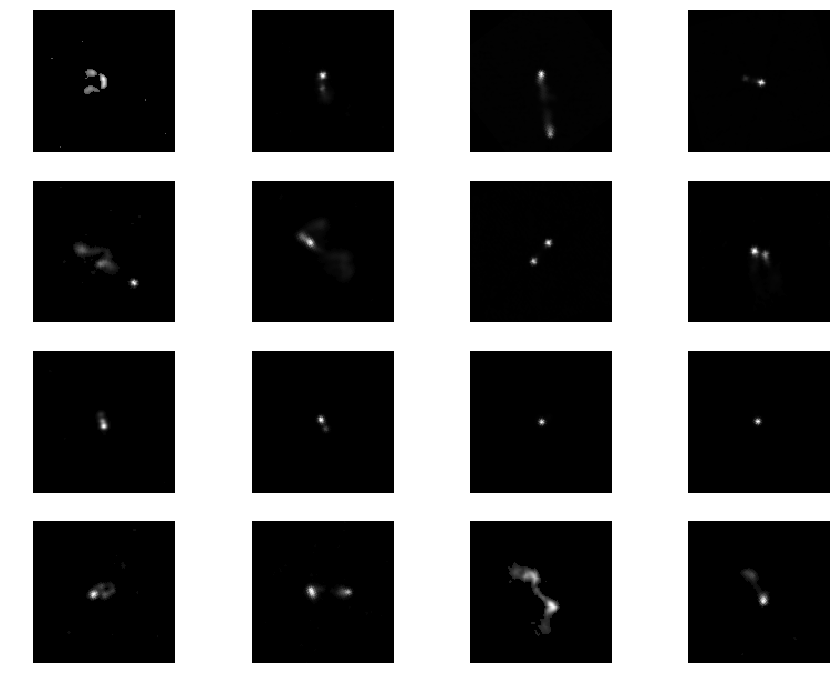

In [39]:
f, ax = plt.subplots(4, 4, figsize=(15, 12))
for i in range(4): 
    for j in range(4):
        ax[i][j].imshow(sample[i*4 + j][0], cmap='gray')
        ax[i][j].axis('off')

In [40]:
with torch.no_grad():
    recon = vae(sample.to(device))[0].cpu()

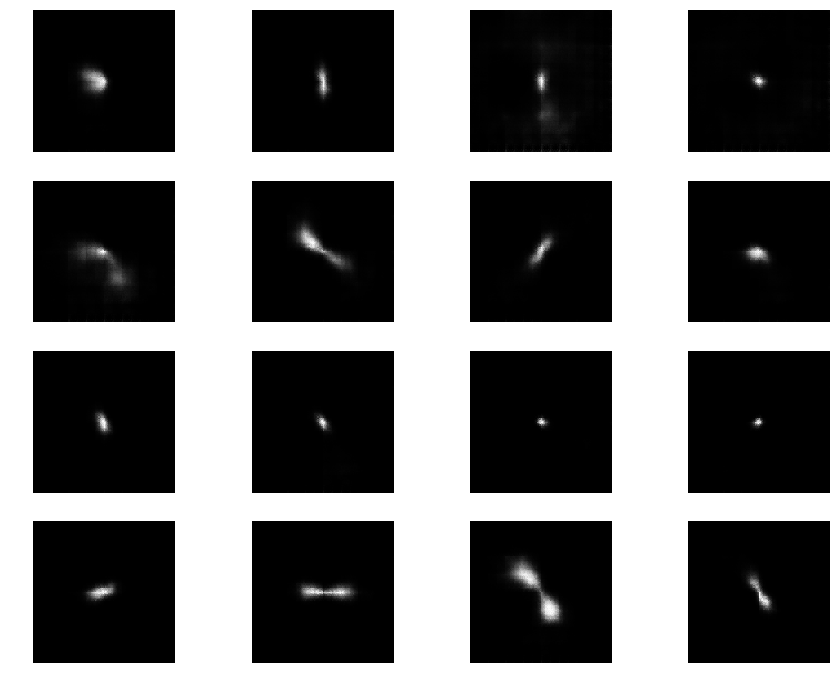

In [41]:
f, ax = plt.subplots(4, 4, figsize=(15, 12))
for i in range(4): 
    for j in range(4):
        ax[i][j].imshow(recon[i*4 + j][0], cmap='gray')
        ax[i][j].axis('off')

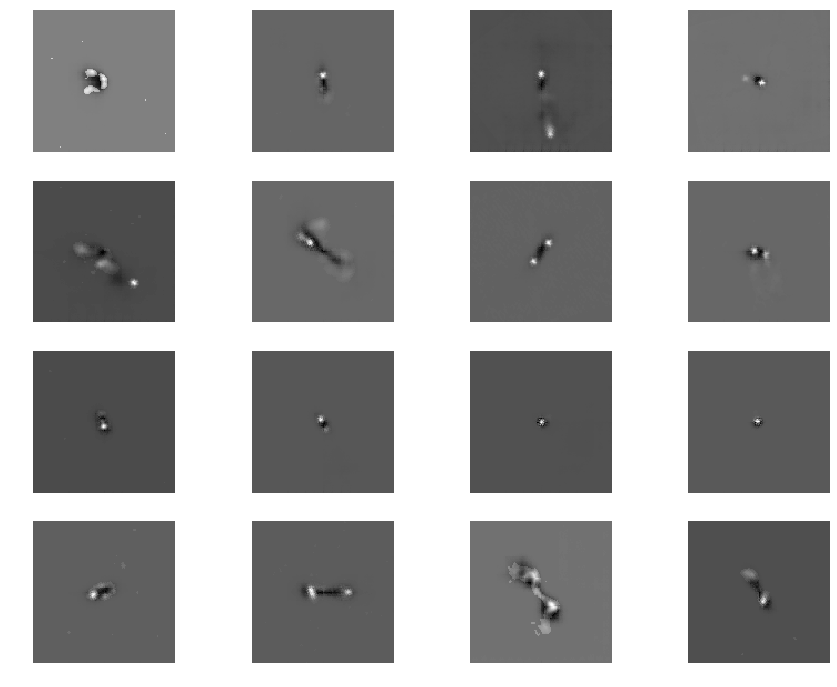

In [42]:
f, ax = plt.subplots(4, 4, figsize=(15, 12))
for i in range(4): 
    for j in range(4):
        o, r = sample[i*4 + j][0], recon[i*4 + j][0] 
        ax[i][j].imshow(o - r, cmap='gray')
        ax[i][j].axis('off')

In [43]:
torch.save(vae, 'vae_gan_model_g')
torch.save(dis, 'vae_gan_model_d')
# cae = torch.load('cae_model')
# cae.eval()

In [44]:
s = sample[4:5]

tensor(0.7614, device='cuda:0')

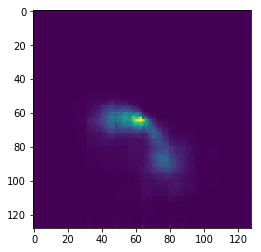

In [45]:
with torch.no_grad():
    e = vae.encode(s.to(device))[0]
#     e[0][0] = -2
    d = vae.decode(e)
plt.imshow(d.cpu()[0][0])
e[0][0]

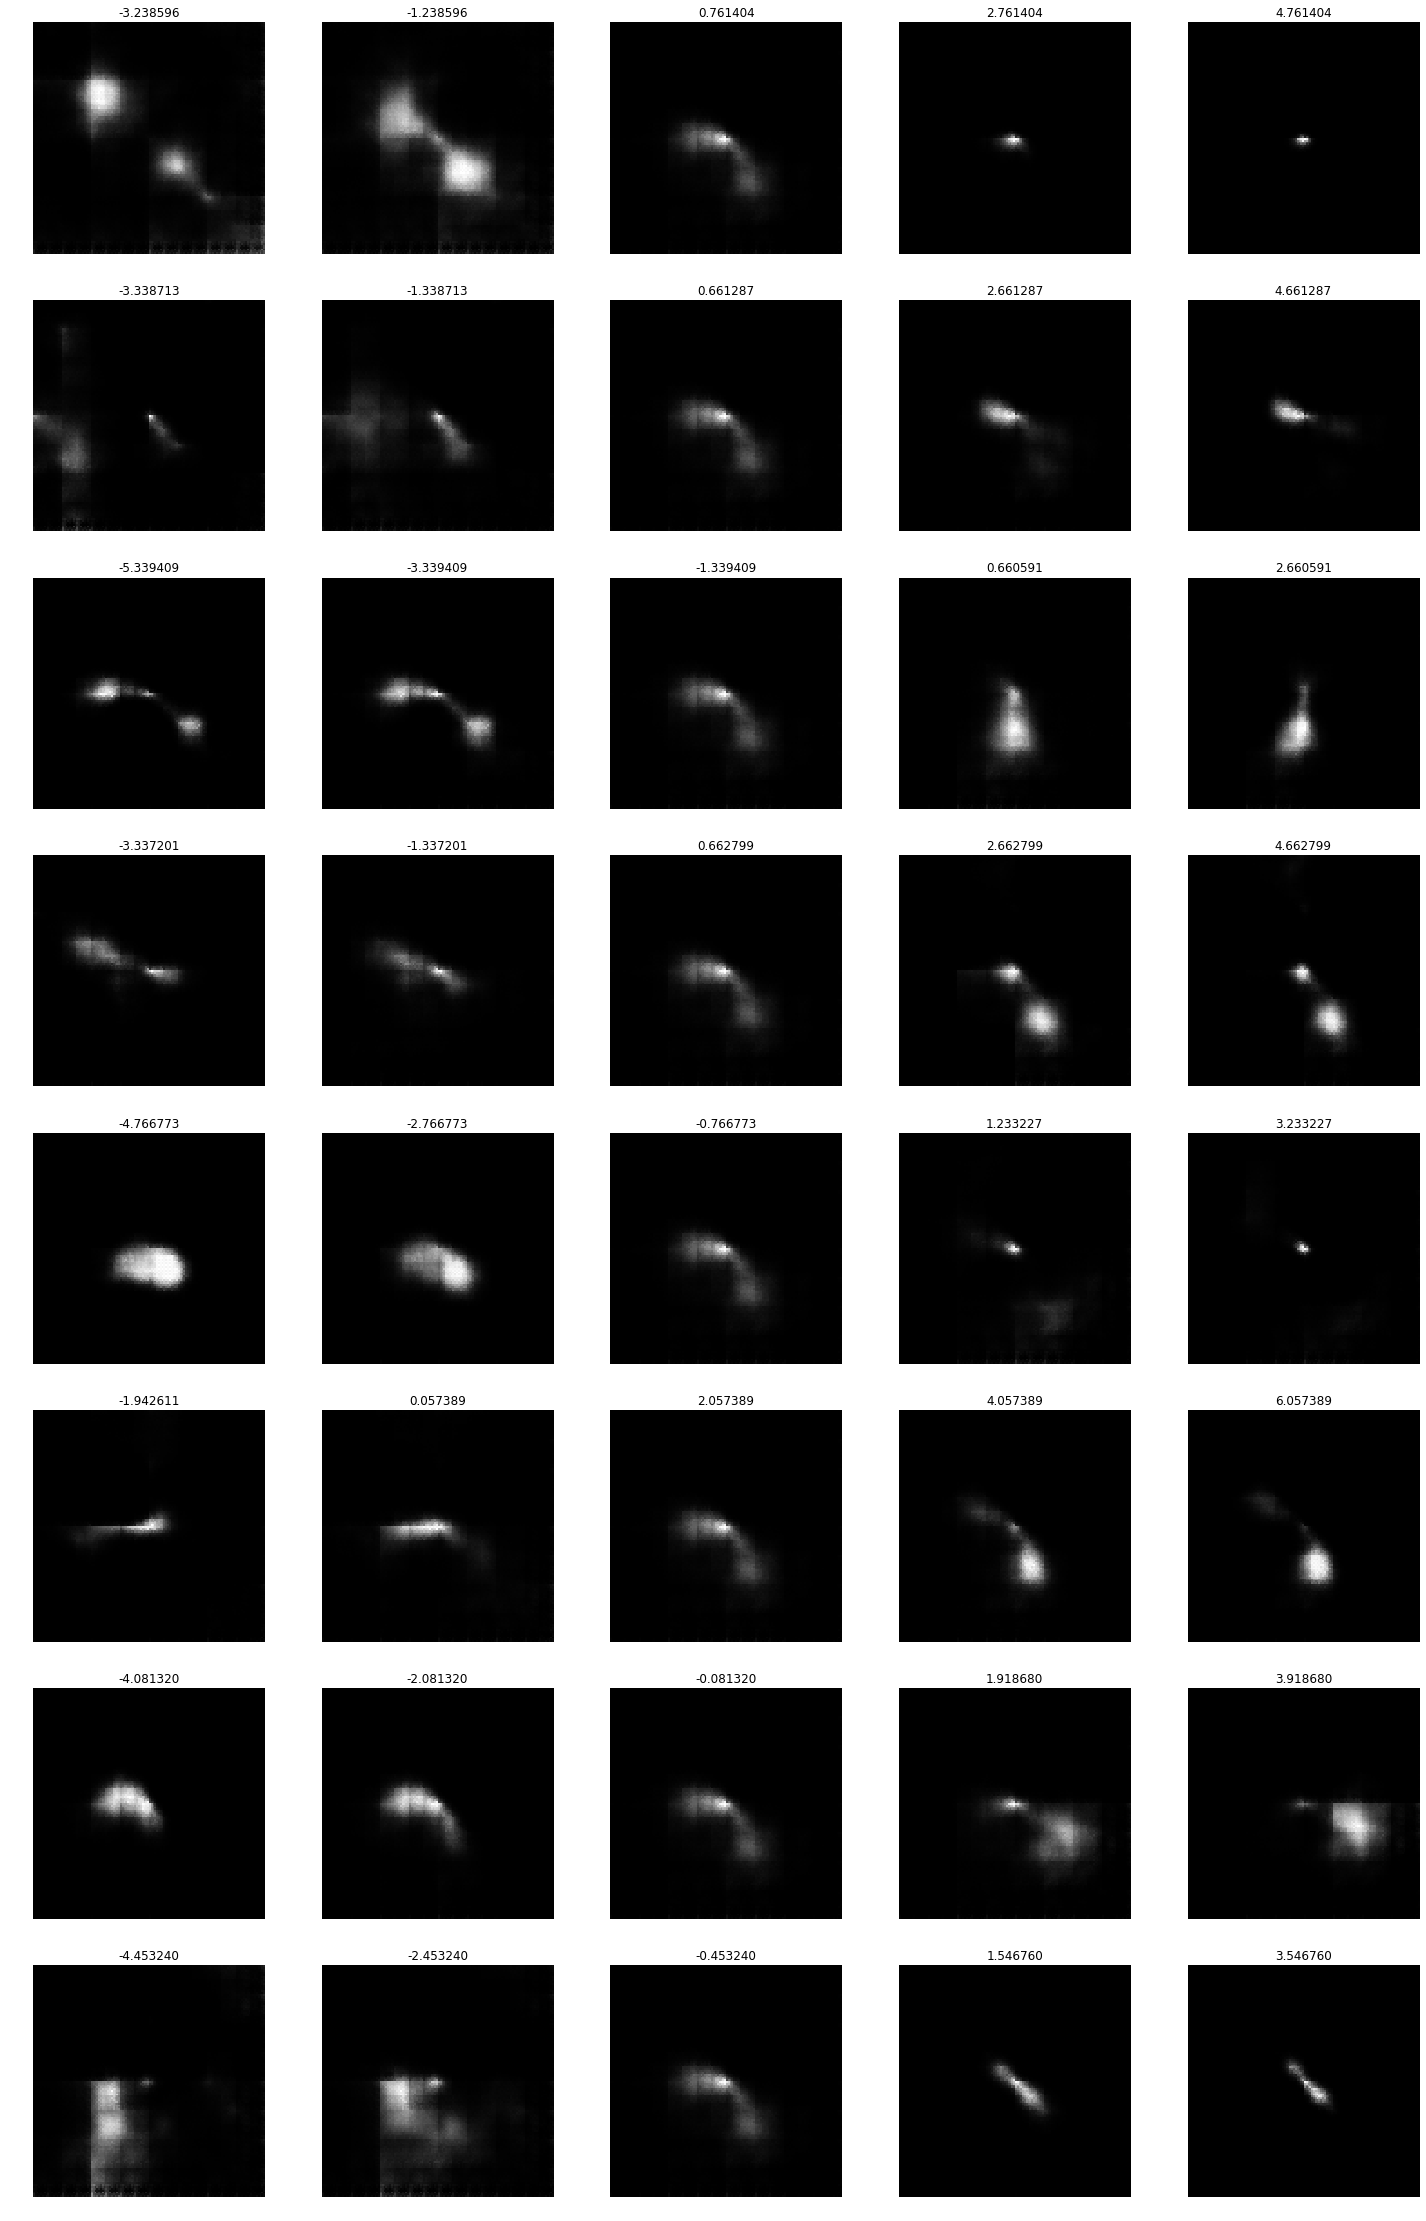

In [48]:
nimg = 5 * 8
r = 5
f, ax = plt.subplots(int(nimg/r), r, figsize=(r * 5, nimg * 5 / r))
for i in range(int(nimg/r)):
    for j in range(r):
        with torch.no_grad():
            e = vae.encode(s.to(device))[0]
            v = e[0][i]
            nv = -4 + v + 2*j
            e[0][i] = nv
            d = vae.decode(e).cpu()[0][0]
        ax[i][j].imshow(d, cmap='gray')
        ax[i][j].axis('off')
        ax[i][j].set_title('{:2f}'.format(nv))